In [1]:
import feather
import sys
sys.path.append("..")
import helpers

In [2]:
df_train = feather.read_dataframe("data/df_train.feather")
df_test = feather.read_dataframe("data/df_test.feather")
df_oot = feather.read_dataframe("data/df_oot.feather")

In [3]:
import numpy as np
from category_encoders import *

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error

import lightgbm as lgb

/Users/xszpo/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [4]:
outliers = [
    {"key":"price", "min":100000, "max":1500000},
    {"key":"flat_size","min":6, "max":150},
    {"key":"year_of_building","min":1850, "max":2050},    
    {"key":"GC_longitude","min":20.5,"max":21.5},
    {"key":"GC_latitude","min":51,"max":52.5}
]

In [5]:
for val in outliers:
    print("{key} != {key} or ({key}>{min} and {key}<{max})".format(**val))
    df_train=df_train.query("{key} != {key} or ({key}>{min} and {key}<{max})".format(**val))

price != price or (price>100000 and price<1500000)
flat_size != flat_size or (flat_size>6 and flat_size<150)
year_of_building != year_of_building or (year_of_building>1850 and year_of_building<2050)
GC_longitude != GC_longitude or (GC_longitude>20.5 and GC_longitude<21.5)
GC_latitude != GC_latitude or (GC_latitude>51 and GC_latitude<52.5)


In [6]:
for val in outliers:
    print("{key} != {key} or ({key}>{min} and {key}<{max})".format(**val))
    df_test=df_test.query("{key} != {key} or ({key}>{min} and {key}<{max})".format(**val))

price != price or (price>100000 and price<1500000)
flat_size != flat_size or (flat_size>6 and flat_size<150)
year_of_building != year_of_building or (year_of_building>1850 and year_of_building<2050)
GC_longitude != GC_longitude or (GC_longitude>20.5 and GC_longitude<21.5)
GC_latitude != GC_latitude or (GC_latitude>51 and GC_latitude<52.5)


In [7]:
for val in outliers:
    print("{key} != {key} or ({key}>{min} and {key}<{max})".format(**val))
    df_oot=df_oot.query("{key} != {key} or ({key}>{min} and {key}<{max})".format(**val))

price != price or (price>100000 and price<1500000)
flat_size != flat_size or (flat_size>6 and flat_size<150)
year_of_building != year_of_building or (year_of_building>1850 and year_of_building<2050)
GC_longitude != GC_longitude or (GC_longitude>20.5 and GC_longitude<21.5)
GC_latitude != GC_latitude or (GC_latitude>51 and GC_latitude<52.5)


In [8]:
np.random.seed(666)

pipe = make_pipeline(
    ColumnTransformer([
        ('cat', helpers.transformColList(),['producer_name','GC_addr_road','GC_addr_neighbourhood',
                                            'GC_addr_suburb','GC_addr_city','GC_addr_state','GC_addr_postcode',
                                            'GC_addr_country']),
        ('num', helpers.PassThroughOrReplace(),['flat_size','rooms','floor','number_of_floors',
                                                'year_of_building','GC_latitude','GC_longitude']),
        ('te_g', TargetEncoder(), 'GC_addr_postcode'),
        ('txt_name', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1,1), 
                               max_features=500, 
                               dtype=np.float32,
                               binary = True, 
                               use_idf=False),'name'),
        ('txt_dscr', TfidfVectorizer(lowercase=True, 
                               ngram_range=(1, 3), 
                               max_features=3000, 
                               dtype=np.float32,
                               use_idf=True),'description'),
    ]),
    )

In [9]:
%%time
train_transform=pipe.fit_transform(df_train, df_train.price)

CPU times: user 1min 55s, sys: 8.6 s, total: 2min 4s
Wall time: 2min 18s


In [10]:
%%time
test_transform=pipe.transform(df_test)
oot_transform=pipe.transform(df_oot)

CPU times: user 21.6 s, sys: 1.58 s, total: 23.2 s
Wall time: 25.4 s


In [33]:
params = {'colsample_bytree': 0.6624318354159208, #feature_fraction
 'learning_rate': 0.15990411055449805,
 'max_bin': 38712,
 'max_depth': 7,
 'min_child_samples': 84, #min_data_in_leaf
 'min_child_weight': 6, #min_sum_hessian_in_leaf
 'n_estimators': 206, #num_iterations
 'num_leaves': 159,
 'reg_alpha': 3.960667919705787e-06, #lambda_l1
 'reg_lambda': 499.85995495490215, #lambda_l2
 'subsample': 0.9022680042341511, #bagging_fraction
 'subsample_for_bin': 144116, #bin_construct_sample_cnt
 'subsample_freq': 0 #bagging_freq
         } 
model = lgb.LGBMRegressor(**params, objective='huber', random_state=666)

In [36]:
%%time
y_log = np.log1p(df_train.price.tolist())
model.fit(train_transform, y_log)

CPU times: user 4min 17s, sys: 8.36 s, total: 4min 26s
Wall time: 1min 30s


LGBMRegressor(boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.6624318354159208, importance_type='split',
       learning_rate=0.15990411055449805, max_bin=38712, max_depth=7,
       min_child_samples=84, min_child_weight=6, min_split_gain=0.0,
       n_estimators=206, n_jobs=-1, num_leaves=159, objective='huber',
       random_state=666, reg_alpha=3.960667919705787e-06,
       reg_lambda=499.85995495490215, silent=True,
       subsample=0.9022680042341511, subsample_for_bin=144116,
       subsample_freq=0)

In [37]:
%%time

y_pred = model.predict(train_transform)
y_pred = np.expm1(y_pred)

r2 = r2_score(df_train.price, y_pred)
med_abs_err = median_absolute_error(df_train.price, y_pred)
mean_abs_err = mean_absolute_error(df_train.price, y_pred)
print("Train set r2 score {}, median absolute error {}, "
      "mean absolute error {}".format(round(r2, 4), int(med_abs_err),
                                      int(mean_abs_err)))

y_pred = model.predict(test_transform)
y_pred = np.expm1(y_pred)

r2 = r2_score(df_test.price, y_pred)
med_abs_err = median_absolute_error(df_test.price, y_pred)
mean_abs_err = mean_absolute_error(df_test.price, y_pred)

print("Test set r2 score {}, median absolute error {}, mean absolute error {}".format(
    round(r2, 4), int(med_abs_err), int(mean_abs_err)))

y_pred = model.predict(oot_transform)
y_pred = np.expm1(y_pred)

r2 = r2_score(df_oot.price, y_pred)
med_abs_err = median_absolute_error(df_oot.price, y_pred)
mean_abs_err = mean_absolute_error(df_oot.price, y_pred)

print("Out of time set  r2 score {}, median absolute error {}, mean absolute error {}".format(
    round(r2, 4), int(med_abs_err), int(mean_abs_err)))


Train set r2 score 0.9253, median absolute error 28927, mean absolute error 46587
Test set r2 score 0.8903, median absolute error 32770, mean absolute error 54243
Out of time set  r2 score 0.8925, median absolute error 35503, mean absolute error 57202
CPU times: user 2.9 s, sys: 185 ms, total: 3.09 s
Wall time: 1.25 s


```
huber
Train set r2 score 0.9253, median absolute error 28927, mean absolute error 46587
Test set r2 score 0.8903, median absolute error 32770, mean absolute error 54243
Out of time set  r2 score 0.8925, median absolute error 35503, mean absolute error 57202
CPU times: user 2.55 s, sys: 44.8 ms, total: 2.6 s
Wall time: 720 ms
```

```
regression_l1
Train set r2 score 0.916, median absolute error 20143, mean absolute error 42961
Test set r2 score 0.8825, median absolute error 31179, mean absolute error 54708
Out of time set  r2 score 0.882, median absolute error 34195, mean absolute error 58205
CPU times: user 2.82 s, sys: 155 ms, total: 2.98 s
Wall time: 1.25 s
```

Plotting feature importances...


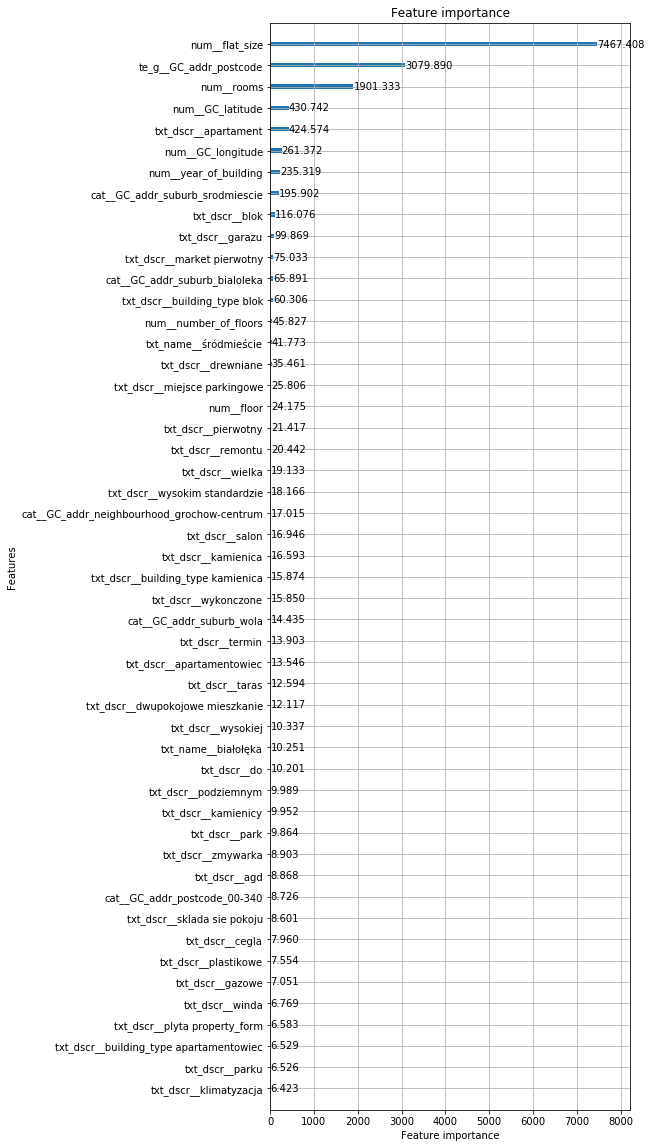

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

print('Plotting feature importances...')
def names(): return pipe.named_steps['columntransformer'].get_feature_names()
model.booster_.feature_name = names
fig, ax = plt.subplots(figsize=(10,20))
fig.subplots_adjust(left=0.4)
lgb.plot_importance(model, max_num_features=50, ax=ax, importance_type = 'gain')
plt.yticks(fontsize=10)
plt.show()